### Calculate power in set frequency bands

In [1]:
import numpy as np
import pandas as pd
import time
from copy import deepcopy
import matplotlib.pyplot as plt
from os.path import join
from spikeinterface.extractors.neoextractors import SpikeGLXRecordingExtractor
from spectral_connectivity import Multitaper, Connectivity
from phylib.io.model import load_model

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Import functions & classes from Yggdrasil library

In [2]:
def get_cluster_depths(data_dir):
    '''Returns dictionary of depths of best channel for each cluster

    Parameters:
        data_dir:    path to sorted spikes directory
    Returns:
        depths:      dictionary, cluster ID -> best channel depth
    '''
    # load the cluster info
    ch_pos = np.load(join(data_dir,'channel_positions.npy'))
    group = pd.read_table(join(data_dir,'cluster_group.tsv'))
    templates = np.load(join(data_dir,'templates.npy'))
    n_templates = len(templates)

    # find the good & MUA clusters
    good_clusters = group['cluster_id'][group['group']== 'good']

    # load TemplateModel instance
    model = load_model(join(data_dir,'params.py'))

    # get y coords of units
    depths = np.zeros(shape=(len(good_clusters),1))
    g = 0
    for index, value in good_clusters.items():
        if value<n_templates: #hacky solution for clusters going beyond templates
            cluster = model.get_template(value)
            depths[g] = ch_pos[cluster.best_channel][1]
            g = g+1
    
    return depths

In [3]:
def plot_ephys_vs_atlas(data_dir, lfp_file):
    '''Plots & saves theta power & # clusters vs channels

    Parameters:
        data_dir:       path to sorted spikes directory
        lfp_file:       path to lf.bin
    '''
    # extract traces & sampling rate
    lfp_data = SpikeGLXRecordingExtractor(lfp_file, stream_id='imec0.lf')
    samp_rate = lfp_data.get_sampling_frequency()

    # get a subset of the data for visualization
    # this takes a 10s chunk 10min into recording, but you can change this (it shouldn't change much)
    sample = lfp_data.get_traces(start_frame=1500000, end_frame=1525000)

    # calculate spectrogram
    window = 0.50  # seconds
    m = Multitaper(sample, sampling_frequency=samp_rate,
                   time_window_duration=window, time_window_step=window)
    c = Connectivity.from_multitaper(m)  # shape: windows x freqs x channels

    # get power in theta band
    freqs = (6, 12)
    band_start = np.argmin(np.abs(c.frequencies - freqs[0]))
    band_end = np.argmin(np.abs(c.frequencies - freqs[1]))
    power = np.mean(np.mean(c.power()[:, band_start:band_end, :].squeeze(), 1), 0)

    # get spike cluster depths
    depths = get_cluster_depths(data_dir)
    hist, bin_edges = np.histogram(depths, bins=np.arange(0., 3860., 20.))
    bin_edges = bin_edges[0:-1]/10

    # plot theta power for each channel & number of clusters at each depth
    # with overlay of atlas registration
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(np.log(power), c='black', label='Theta')
    ax.plot(bin_edges, hist, c='grey', label='Clusters')
    fig.legend(loc='upper right')
    y_limits = ax.get_ylim()
    y_limit = y_limits[1] - (y_limits[1]-y_limits[0])/5
    ax.set(xlabel='Channel', ylabel='Log(Power) OR # Clusters')

In [4]:
import re
import glob
from os.path import exists
import numpy as np
import pandas as pd
from copy import deepcopy
from scipy import signal
import matplotlib.pyplot as plt
from spikeinterface.extractors.neoextractors import SpikeGLXRecordingExtractor
from spectral_connectivity import Multitaper, Connectivity
from scipy.signal import filtfilt, remez


class LFP:

    '''LFP and related functions from a single session

    Attributes:
        name (string):               path to LFP file
        rec_file_path (string):      path to spikeGLX folder containing lf.bin
        lfp (ts x channels float):   array of LFP voltage values
        timestamps (1xts float):     array of timestamps
        start (int):                 start time (s)
        end (int):                   end time (s)
        rate (int):                  samples/s of downsampled stream
        n_chan (int):                # channels
        downsample_factor (int):     downsample factor
        max_theta_channel (int):     index of channel with highest theta power
                                        within user-specified channel subset & time subset

    Methods:
        load
        save
        subset_by_channel
        subset_by_time
        calc_max_theta_channel

    Functions:
        get_inclusive_indices
        multitaper_filtered_power
        plot_spectrogram
        plot_psd
        design_filter
        bandpass_filter
        hilbert_envelope_phase_freq
        get_cycle_intervals
    '''

    def __init__(self, name="", rec_file_path="", start=None, end=None, n_chan=384, 
                 probe_type=1, downsample_factor=4, channels=None):
        '''Loads or builds spiketimes and relevant variables

        Parameters:
            name (string):              optional, path to LFP file
            rec_file_path (string):     optional, path to spikeGLX folder with lf.bin
            start (int):                optional, start time (sec)
            end (int):                  optional, end time (sec)
            n_chan (int):               optional, # channels
            probe_type (int):           optional, NPX probe type (1 or 2)
            downsample_factor (int):    optional, downsample factor
            channels (list of ints):    optional, indices of channels to include
        '''

        self.name = name

        # if instance already defined
        if exists(self.name):
            self.load()
        else:
            self.rec_file_path = rec_file_path
            self.start = start
            self.end = end
            self.n_chan = n_chan
            self.downsample_factor = downsample_factor
            self.rate = 2500

            # design filter
            hardware_filter = signal.butter(
                1, Wn=[0.5, 500], btype='band', fs=self.rate)
            # preprocess_filter = signal.butter(12, Wn=[1,500], btype='band', fs=self.rate) #catGT specs
            preprocess_filter = signal.butter(
                2, Wn=[0.1, 300], btype='band', fs=self.rate)  # Frank lab specs

            lfp_extractor = SpikeGLXRecordingExtractor(self.rec_file_path, \
                                                       stream_id='imec0.lf')
            
            if self.start is None:
                self.start = 0
            if self.end is None:
                ap_meta_file = glob.glob(join(ephys_path,'*.imec0.ap.meta'))
                file_stream = open(ap_meta_file[0])
                for line in file_stream:
                    if 'fileTimeSecs' in line:
                        self.end = float(re.findall(r'(\d+\.\d+)', line)[0])
            
            # ts x channels empty ndarray
            n_samp = int((self.end*self.rate-self.start * \
                         self.rate)/self.downsample_factor)+1
            self.lfp = np.empty((n_samp, self.n_chan))
            
            if channels is None:
                channels = list(range(n_chan))

            for i, c in enumerate(channels):
                # subsetted by channel to reduce RAM requirements
                lfp_c = lfp_extractor.get_traces(channel_ids=[f"imec0.lf#LF{c}"],
                                                start_frame=int(self.start*self.rate),
                                                end_frame=int(self.end*self.rate))
                lfp_c = lfp_c.T

                if probe_type==1:
                    # correct for analog filter phase shift
                    # reverse, filter in 1 direction, and reverse again
                    lfp_c = np.flip(signal.lfilter(*hardware_filter, np.flip(lfp_c)))
    
                    # initial filtering (similar to what catGT would have done)
                    lfp_c = signal.filtfilt(*preprocess_filter, lfp_c)

                # downsample to reduce filesize
                downsampled_lfp = signal.decimate(
                    lfp_c, self.downsample_factor)
                # the sglx recording extractor sometimes cuts off the last few LFP datapoints
                # so leaves those blank in the LFP array
                self.lfp[0:len(downsampled_lfp[0]), i] = downsampled_lfp

            # store timestamps for future temporal filtering
            self.rate = self.rate/self.downsample_factor  # new downsampled rate
            self.timestamps = np.arange(0, self.end-self.start, 1/self.rate)

    def load(self):
        '''Load position file'''
        # load metadata as text file, data as csv
        name = self.name
        meta_name = self.name[:-4]+'_metadata.txt'
        file = open(meta_name, 'r')
        self.__dict__ = eval(file.read())
        self.name = name

        with open(self.name, "r") as file:
            lfp_df = pd.read_csv(file)
        self.timestamps = np.array(lfp_df['Timestamps'])
        self.lfp = np.array(lfp_df)
        self.lfp = self.lfp[:, 1:]  # remove Timestamps column

    def save(self):
        '''Save position to file'''
        # save metadata as text file, data as csv
        lfp = deepcopy(self.lfp)
        del self.lfp
        timestamps = deepcopy(self.timestamps)
        del self.timestamps

        meta_name = self.name[:-4]+'_metadata.txt'
        with open(meta_name, 'w') as file:
            file.write(str(self.__dict__))

        ts_df = pd.DataFrame(data=timestamps, columns=['Timestamps'])
        lfp_df = pd.DataFrame(data=lfp)
        lfp_df = pd.concat([ts_df, lfp_df], axis=1)
        lfp_df.to_csv(self.name, index=False)

        self.lfp = lfp
        self.timestamps = timestamps

    # %% Subsetting functions
    def subset_by_channel(self, subset_channels):
        '''Subset lfp on specific channels, eg after running electrodes.subset_by_location()'''
        self.lfp = self.lfp[:, subset_channels]
        self.n_chan = len(subset_channels)

    def subset_by_time(self, intervals):
        '''Subset lfp within windows, e.g. during epochs or running'''
        if intervals.ndim == 1:  # if just 1 interval
            # convert vector to 2D array with 1 row
            intervals = intervals[np.newaxis]

        # append all timestamps within the windows (inclusive)
        subset_timestamps = np.empty(0)
        subset_indices = np.empty(0)
        for i in intervals:
            subset_timestamps = np.append(subset_timestamps,
                                          self.timestamps[(self.timestamps >= i[0])
                                                          & (self.timestamps <= i[1])])
            subset_indices = np.append(subset_indices,
                                       np.asarray(np.where((self.timestamps >= i[0])
                                                           & (self.timestamps <= i[1]))))

        # append all lfp samples within the windows (inclusive)
        subset_indices = subset_indices.astype(int)
        subset_lfp = self.lfp[subset_indices, :]

        self.lfp = subset_lfp
        self.timestamps = subset_timestamps

    # %% Calculating features
    def calc_max_theta_channel(self, channels, interval):
        '''Calculate & store the channel with the highest theta power'''
        lfp_theta = deepcopy(self)
        lfp_theta.subset_by_time(interval)
        lfp_theta.subset_by_channel(channels)
        power = multitaper_filtered_power(
            lfp_theta.lfp, low=THETA[0], high=THETA[1])
        self.max_theta_channel = channels[np.argmax(power)]


# %% Filter parameters
# freq band = [low, high, bandpass]
THETA = [5, 11, 1]
SLOW_WAVE = [1, 4, 0.5]
SPINDLE = [12, 18, 1]
SHARP_WAVE = [0, 30, 5]
SLOW_GAMMA = [20, 50, 5]
FAST_GAMMA = [50, 110, 5]
RIPPLE = [125, 200, 5]

# %% External functions


def get_inclusive_indices(low, high, freqs):
    '''Find the indices of the target band (inclusive)
    Can also use np.argmin(np.abs(c.frequencies - freqs[0]))
    But this method ensures freqs[low_idx]<=low and freqs[high_idx]>=high'''
    low_idx = 0
    high_idx = len(freqs)-1
    for i, freq in enumerate(freqs):
        if (freq > low) and (freqs[i-1] < low):
            low_idx = i-1
        if (freq > high) and (freqs[i-1] < high):
            high_idx = i
            break
    return low_idx, high_idx


def multitaper_filtered_power(lfp, rate=625, low=1, high=300, window=0.5):
    '''Use multi-taper spectrogram to calculate power in freq. window'''
    # calculate spectrogram
    m = Multitaper(lfp, sampling_frequency=rate,
                   time_window_duration=window, time_window_step=window)
    c = Connectivity.from_multitaper(m)  # shape: windows x freqs x channels

    # get power in freq band
    band_start, band_end = get_inclusive_indices(low, high, c.frequencies)
    power = np.mean(c.power()[:, band_start:band_end, :].squeeze(), 1)
    total_power = np.mean(power, 0)
    return power, total_power


def plot_spectrogram(lfp, rate=625, low=1, high=300, low_display=1,
                     high_display=300, window=0.5):
    '''Use multi-taper spectrogram to plot power across all freqs in window on a single channel'''
    # calculate spectrogram
    m = Multitaper(lfp, sampling_frequency=rate,
                   time_window_duration=window, time_window_step=window)
    c = Connectivity.from_multitaper(m)  # shape: windows x freqs x channels

    # find the target bands (inclusive)
    low_idx, high_idx = get_inclusive_indices(low, high, c.frequencies)
    low_disp_idx, high_disp_idx = get_inclusive_indices(
        low_display, high_display, c.frequencies)

    # extract power and timestamps
    power = np.mean(c.power()[:, low_idx:high_idx, 0].squeeze(), 1)
    n_samples = int(window * rate)
    timestamps = np.arange(0, lfp.shape[0])
    index = timestamps[np.arange(1, power.shape[0] * n_samples + 1, n_samples)]
    power = pd.DataFrame(power, index=index)
    timestamps = power.index/rate

    # plot spectrogram
    f, ax = plt.subplots(figsize=(10, 10))
    ax.pcolormesh(timestamps, c.frequencies[low_disp_idx:high_disp_idx],
                  c.power()[:, low_disp_idx:high_disp_idx, 0].squeeze().T, cmap='viridis')
    ax.set(xlabel='Time (s)', ylabel='Frequency (Hz)')

    # plot theta power over time
    f, ax = plt.subplots(figsize=(10, 3))
    ax.plot(timestamps, power.values)
    ax.set(xlabel='Time (s)', ylabel='Theta Power (uV)',
           xlim=[timestamps[0], timestamps[-1]])


def plot_psd(lfp, rate=625):
    '''Plots PSD for a single channel'''
    freqs, psd = signal.welch(np.squeeze(lfp), rate)
    plt.semilogy(freqs, psd)
    plt.xlim([0, 200])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (V**2/Hz)')
    plt.show()

# following 2 functions adapted from
# https://github.com/Eden-Kramer-Lab/ripple_detection/blob/master/ripple_detection/core.py


def design_filter(rate=625, low=1, high=300, pass_band=1):
    '''Returns a remez (aka equiripple) bandpass filter
    Parameters
    ----------
    samp_rate : sampling frequency (Hz)
    freqs : tuple of low & high freqs (Hz)
    pass_band : width of pass band (Hz)
    Returns
    -------
    filtered_data : array_like, shape (n_time,)
    '''
    order = 101
    nyquist = 0.5*rate
    desired = [0, low - pass_band, low,
               high, high + pass_band, nyquist]
    return remez(order, desired, [0, 1, 0], Hz=rate), 1.0


def bandpass_filter(lfp, rate=625, low=1, high=300, pass_band=1):
    '''Returns a bandpass filtered signal
    Parameters
    ----------
    data : array_like, shape (n_time,)
    samp_rate : sampling frequency (Hz)
    freqs : tuple of low & high freqs (Hz)
    pass_band : width of pass band (Hz)
    Returns
    -------
    filtered_data : array_like, shape (n_time,)
    '''
    filt_num, filt_denom = design_filter(rate, low, high, pass_band)
    is_nan = np.isnan(lfp)
    filtered_data = np.full_like(lfp, np.nan)
    filtered_data[~is_nan] = filtfilt(
        filt_num, filt_denom, lfp[~is_nan], axis=0)
    return filtered_data


def hilbert_envelope_phase_freq(lfp, win=15, rate=625):
    '''Hilbert transform to get envelope, phase, and frequency of LFP'''
    # smooth filtered signal
    filter_coef = signal.get_window('hann', win, fftbins=False)
    filter_coef /= filter_coef.sum()
    # filtfilt is expecting (channel x timestamps) shape
    smoothed_lfp = signal.filtfilt(filter_coef, 1, lfp.T)
    # multiple by -1 so cycle is peak-to-peak instead of trough-to-trough
    smoothed_lfp = smoothed_lfp.T*-1 
    
    # hilbert transform
    analytic_signal = signal.hilbert(smoothed_lfp, axis=0)
    envelope = np.abs(analytic_signal)
    inst_phase = np.unwrap(np.angle(analytic_signal))
    inst_freq = (np.diff(inst_phase, axis=0)/(2.0*np.pi)*rate)
    return envelope, inst_phase, inst_freq


def get_cycle_intervals(lfp, timestamps, win=15, rate=625):
    '''Given a (theta-filtered) 1-channel LFP trace, returns a (i,2) nparray of i intervals
    where [intervals[i,0], intervals[i,1]] spans a single (theta) cycle
    '''
    _, phase, _ = hilbert_envelope_phase_freq(lfp, win, rate)
    new_cycle = np.diff(phase, axis=0) < 0
    new_cycle = np.append(new_cycle, [False])  # match length to timestamps
    curr_start = timestamps[0]
    intervals = []
    start_indices = [0]
    for t, time in enumerate(timestamps):
        # when phase shifts from high (~2pi) to low (~0), start a new cycle
        if new_cycle[t]:
            intervals.append([curr_start, timestamps[t-1]])
            start_indices.append(t-1)
            curr_start = timestamps[t-1]
        # end of the array without hitting an interval-ending new cycle
        elif t == len(timestamps)-1:
            intervals.append([curr_start, timestamps[t]])
            start_indices.append(t)

    start_indices = start_indices[:-1]  # remove end index
    return intervals, start_indices


### Read session list and calculate power in each frequency band over time

In [5]:
sessions = pd.read_csv(r'\\oak-smb-giocomo.stanford.edu\groups\giocomo\fkmasuda\fkm_analysis\EAJ_revisions\wt_ket_sessions.csv')
sessions

,Animal,Session,Control_Injx,Ketamine_Injx,LFP_Channel
0,G1,G1_190817,1158.42,2177.72,50.0
1,G1,G1_190818,979.34,4035.04,50.0
2,G2,G2_190712,647.82,1163.82,100.0
3,G2,G2_190714,832.88,1838.84,50.0
4,G2,G2_190715,2147.40,2942.16,50.0
5,G2,G2_190716,981.98,1777.16,100.0
6,G3,G3_190703,569.04,1649.88,200.0
7,G3,G3_190704,540.58,1148.70,150.0
8,G3,G3_190705,589.20,1155.12,200.0
9,G3,G3_190708,600.34,3225.66,100.0


\\oak-smb-giocomo.stanford.edu\groups\giocomo\export\data\Projects\JohnKei_NPH3\G1\G1_190817_keicontrasttrack_ketamine1_g0\G1_190817_keicontrasttrack_ketamine1_g0_imec0
\\oak-smb-giocomo.stanford.edu\groups\giocomo\export\data\Projects\JohnKei_NPH3\G1\G1_190818_keicontrasttrack_ketamine1_g0\G1_190818_keicontrasttrack_ketamine1_g0_imec0
\\oak-smb-giocomo.stanford.edu\groups\giocomo\export\data\Projects\JohnKei_NPH3\G2\G2_190712_keicontrasttrack_ketamine1_g0\G2_190712_keicontrasttrack_ketamine1_g0_imec0
\\oak-smb-giocomo.stanford.edu\groups\giocomo\export\data\Projects\JohnKei_NPH3\G2\G2_190714_keicontrasttrack_ketamine1_g0\G2_190714_keicontrasttrack_ketamine1_g0_imec0
\\oak-smb-giocomo.stanford.edu\groups\giocomo\export\data\Projects\JohnKei_NPH3\G2\G2_190715_keicontrasttrack_ketamine1_g0\G2_190715_keicontrasttrack_ketamine1_g0_imec0
\\oak-smb-giocomo.stanford.edu\groups\giocomo\export\data\Projects\JohnKei_NPH3\G2\G2_190716_keicontrasttrack_ketamine1_g0\G2_190716_keicontrasttrack_ketam

FileNotFoundError: [Errno 2] No such file or directory: '\\\\oak-smb-giocomo.stanford.edu\\groups\\giocomo\\export\\data\\Projects\\JohnKei_NPH3\\G4\\G4_190620_keicontrasttrack_ketamine1_g0\\G4_190620_keicontrasttrack_ketamine1_g0_imec0\\cluster_group.tsv'

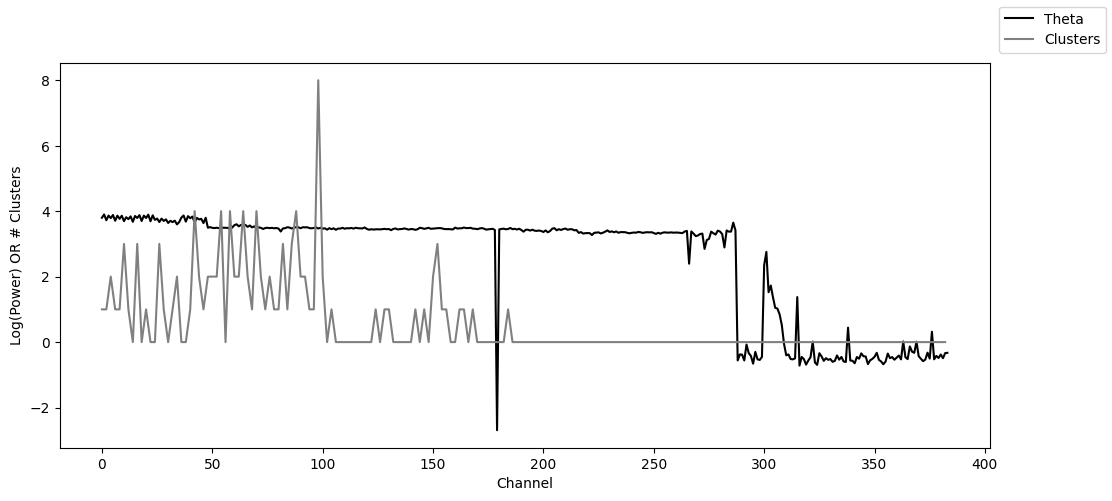

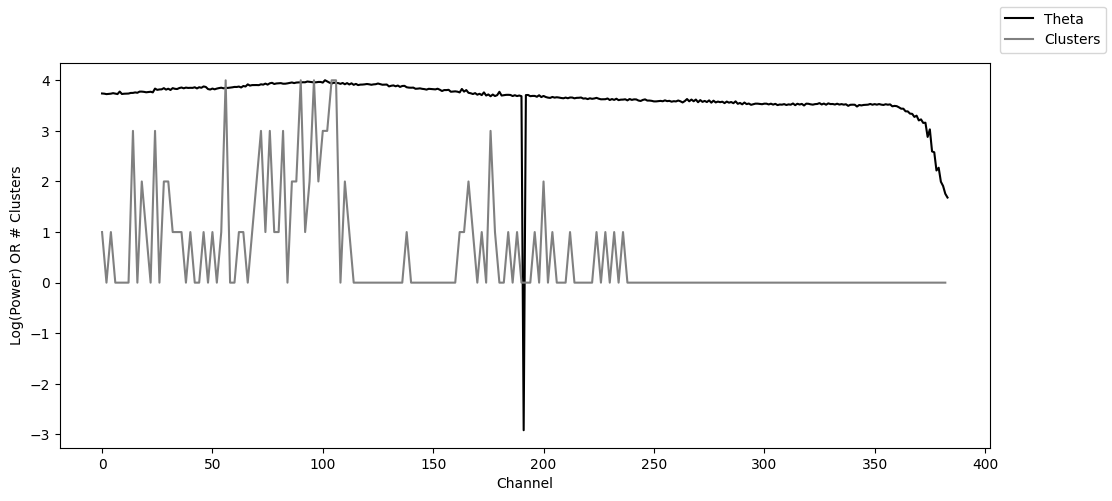

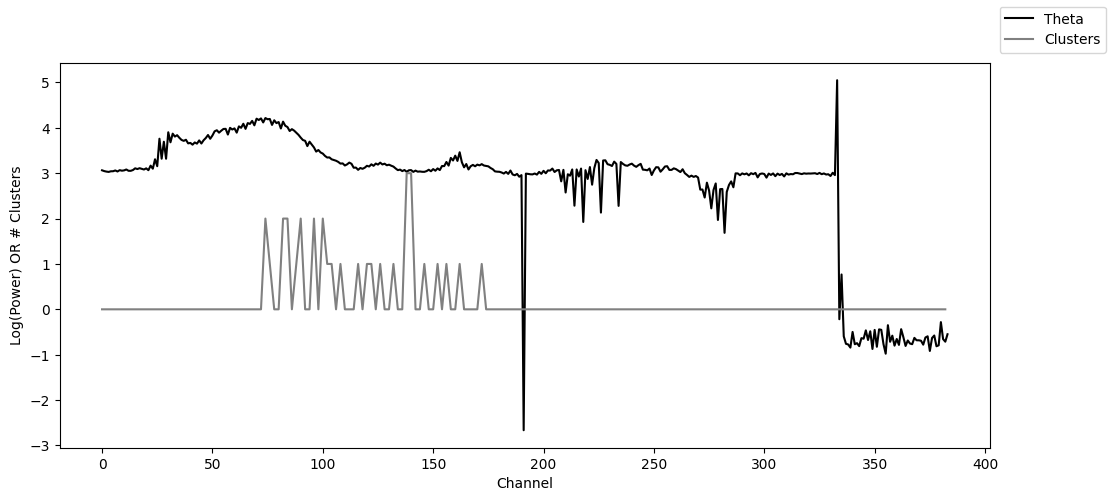

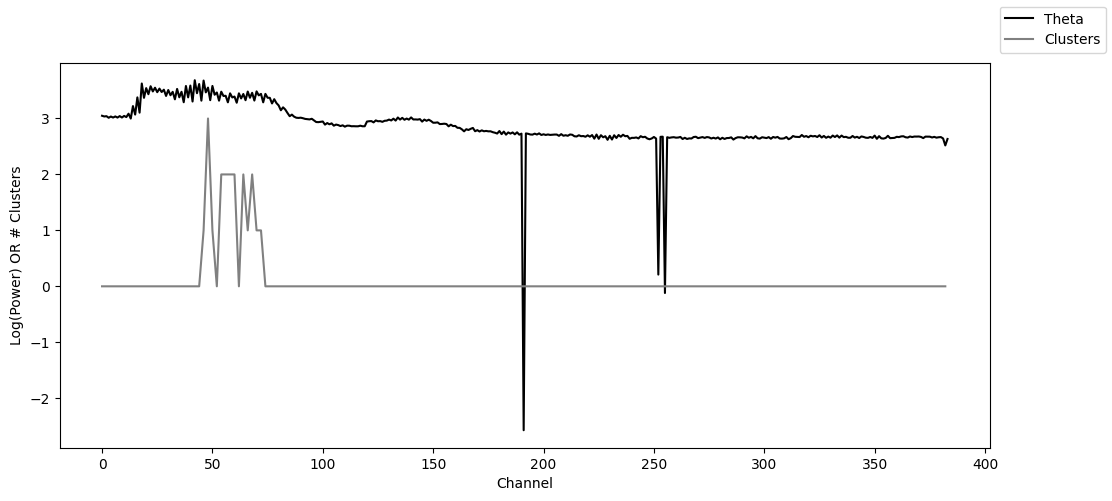

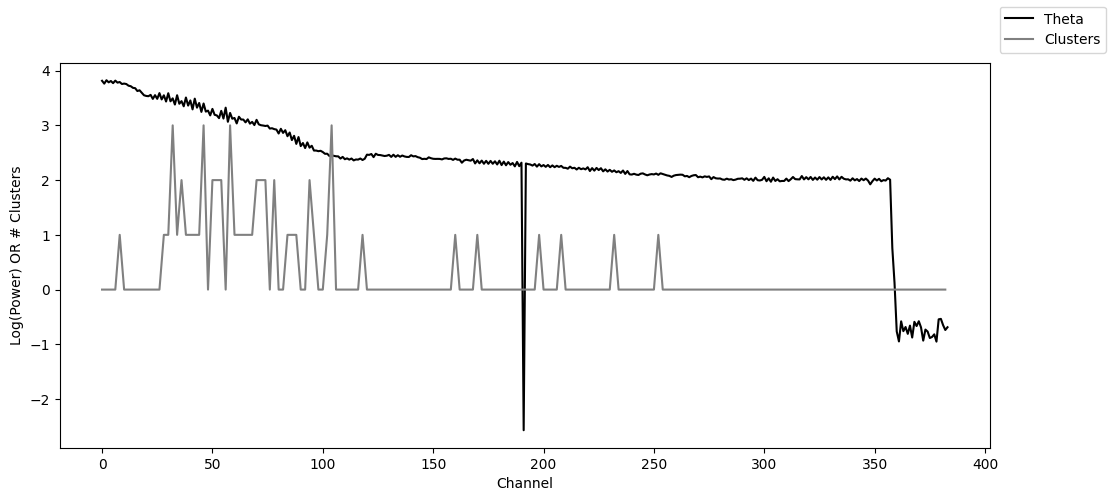

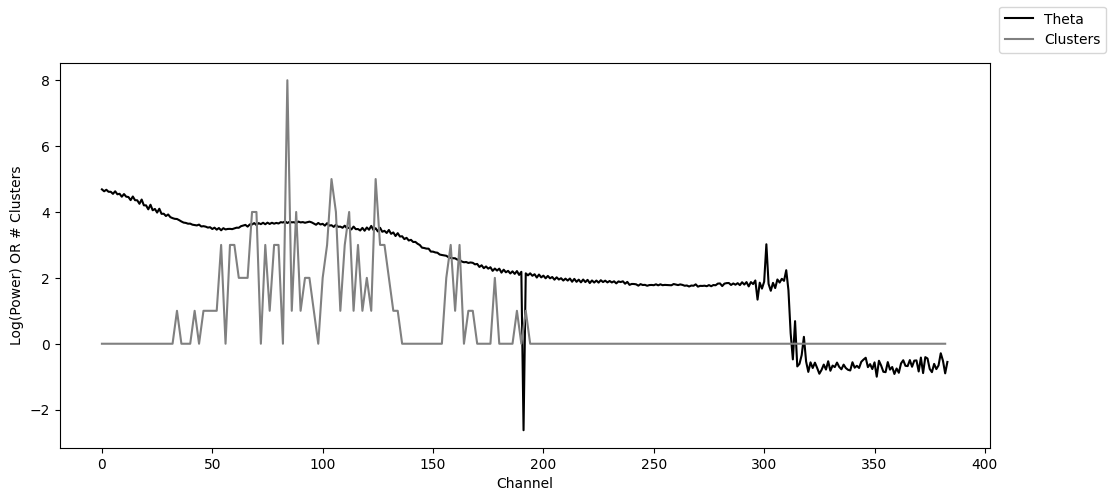

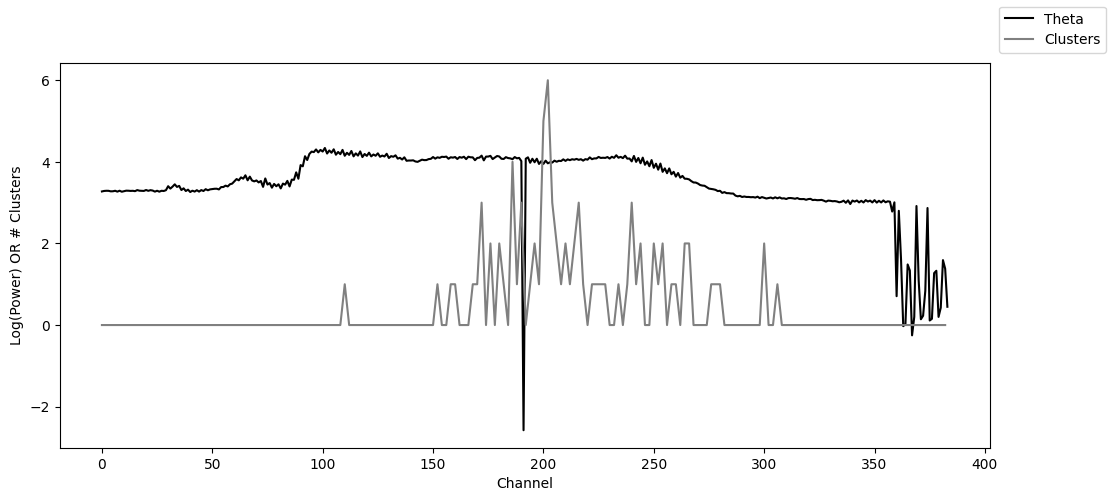

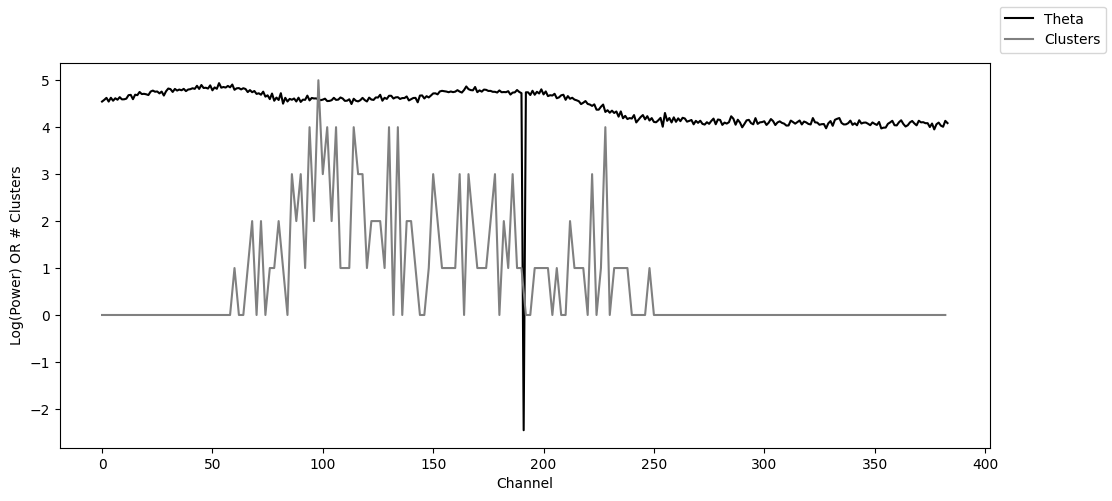

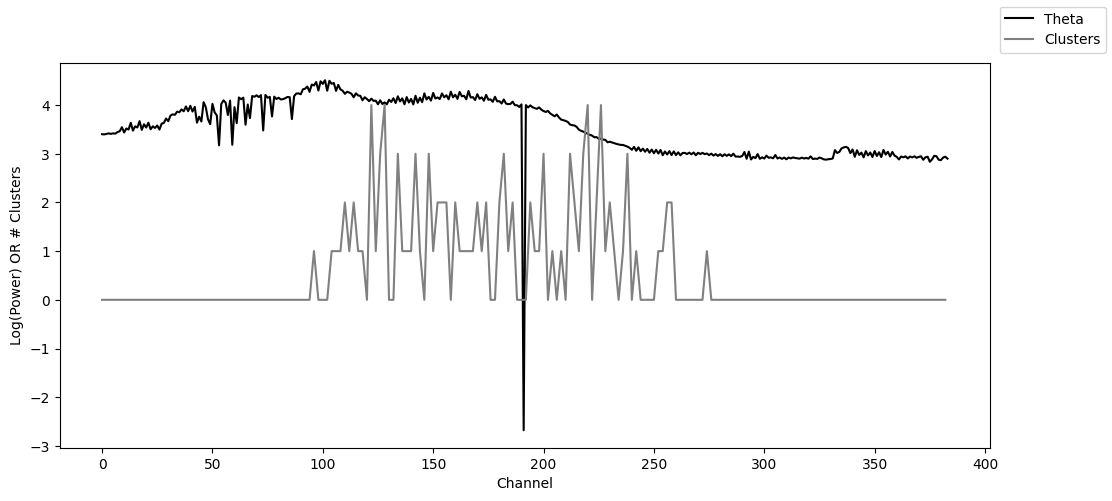

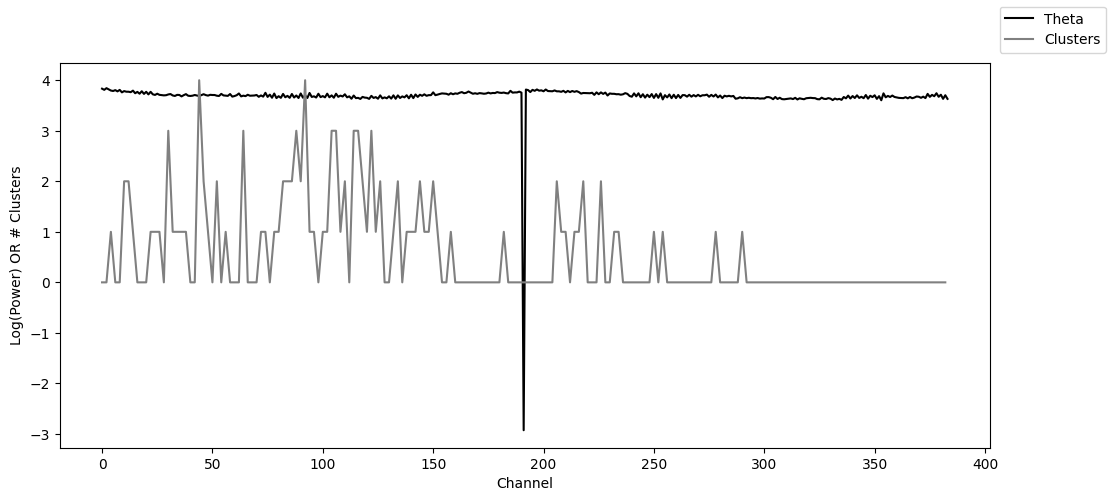

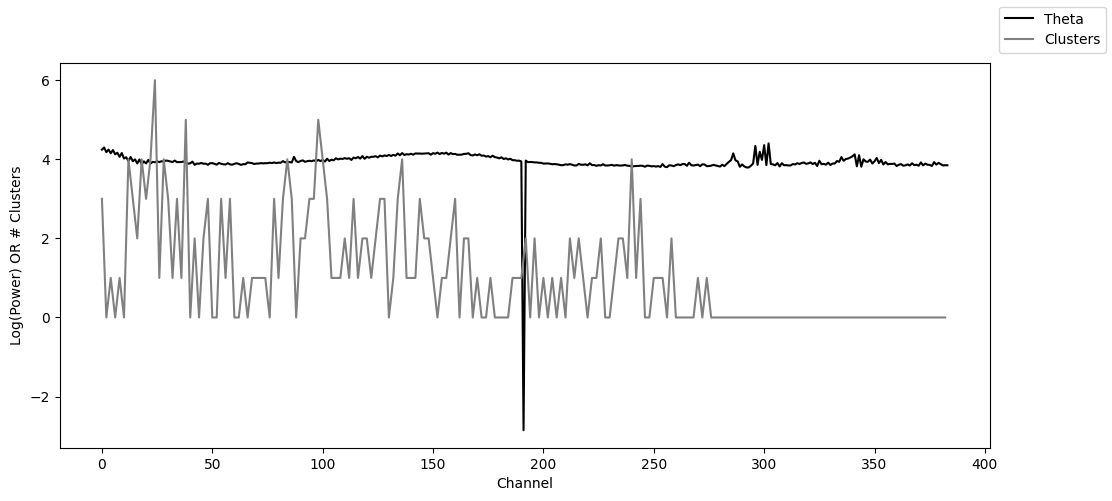

In [18]:
ephys_base_dir = r'\\oak-smb-giocomo.stanford.edu\groups\giocomo\export\data\Projects\JohnKei_NPH3'
rec_suffix = 'keicontrasttrack_ketamine1'
for i, row in sessions.iterrows():
    rec_base = row['Session']+'_'+rec_suffix
    ephys_path = join(ephys_base_dir, row['Animal'], rec_base+'_g0', rec_base+'_g0_imec0')
    lfp_file = join(ephys_path, rec_base+'_g0_tcat.imec0.lf.bin')
    ks_file_path = ephys_path
    print(ephys_path)
    plot_ephys_vs_atlas(ks_file_path, ephys_path)

In [8]:
t = time.time()
output_dir = r'\\oak-smb-giocomo.stanford.edu\groups\giocomo\fkmasuda\fkm_analysis\EAJ_revisions\lfp'
ephys_base_dir = r'\\oak-smb-giocomo.stanford.edu\groups\giocomo\export\data\Projects\JohnKei_NPH3'
rec_suffix = 'keicontrasttrack_ketamine1'
for i, row in sessions.iloc[0:1].iterrows():
    rec_base = row['Session']+'_'+rec_suffix
    ephys_path = join(ephys_base_dir, row['Animal'], rec_base+'_g0', rec_base+'_g0_imec0')
    lfp_file = join(ephys_path, rec_base+'_g0_tcat.imec0.lf.bin')
    print(ephys_path)
    lfp = LFP(rec_file_path=ephys_path, channels=[int(row['LFP_Channel'])], probe_type=2, n_chan=1)
    tp, theta_power = multitaper_filtered_power(lfp.lfp, low=THETA[0], high=THETA[1], window=1)
    #_, SG_power = multitaper_filtered_power(lfp.lfp, low=SLOW_GAMMA[0], high=SLOW_GAMMA[1], window=1)
    #_, FG_power = multitaper_filtered_power(lfp.lfp, low=FAST_GAMMA[0], high=FAST_GAMMA[1], window=1)
    ####theta_df = pd.DataFrame(data=theta_power)
    ####theta_df.to_csv(join(output_dir, row['Session']+'_theta_power.csv'))
print(time.time()-t)

\\oak-smb-giocomo.stanford.edu\groups\giocomo\export\data\Projects\JohnKei_NPH3\G1\G1_190817_keicontrasttrack_ketamine1_g0\G1_190817_keicontrasttrack_ketamine1_g0_imec0


IndexError: index 50 is out of bounds for axis 1 with size 1

In [ ]:
t = time.time()
for i, row in sessions.iloc[0:1].iterrows():
    rec_base = row['Session']+'_'+rec_suffix
    ephys_path = join(ephys_base_dir, row['Animal'], rec_base+'_g0', rec_base+'_g0_imec0')
    lfp_file = join(ephys_path, rec_base+'_g0_tcat.imec0.lf.bin')
    print(ephys_path)
    lfp = LFP(rec_file_path=ephys_path, channels=[int(row['LFP_Channel'])], probe_type=2, n_chan=1)
    baseline = deepcopy(lfp)
    baseline = baseline.subset_by_time([0, row['Control_Injx']])
    control = deepcopy(lfp)
    control = control.subset_by_time([row['Control_Injx'], row['Ketamine_Injx']])
    ketamine = deepcopy(lfp)
    ketamine = control.subset_by_time([row['Ketamine_Injx'], row['Ketamine_Injx']+1337])
    baseline_theta, baseline_theta_trace = multitaper_filtered_power(baseline.lfp, low=THETA[0], high=THETA[1], window=1)
    control_theta, control_theta_trace = multitaper_filtered_power(baseline.lfp, low=THETA[0], high=THETA[1], window=1)
    ketamine_theta, ketamine_theta_trace = multitaper_filtered_power(baseline.lfp, low=THETA[0], high=THETA[1], window=1)
print(time.time()-t)

In [ ]:
print(f"%f %f %f", baseline_theta, control_theta, ketamine_theta)
plt.plot(baseline_theta_trace)
plt.plot(control_theta_trace)
plt.plot(ketamine_theta_trace)